# Ex8

## Load and import

In [3]:
import torch
import MNIST_dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch import nn, optim
from typing import Dict, Optional, Tuple, List
import sys

# %% set torches random seed
torch.random.manual_seed(0)

# File manager
PATH = os.getcwd()
data_loc = os.path.join(PATH,'data')
# make fodler for exercise 7 and 8
data_loc_ex78 = os.path.join(data_loc,'ex78')
# os.mkdir(data_loc_ex78) 
# print(data_loc_ex78)

data_loc_MNSIST = os.path.join(data_loc,os.path.abspath("."),"MNIST")
# print(data_loc_MNSIST)

batch_size = 64
# device fridenly not at all
if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc_MNSIST, batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

## Load model

In [7]:
# %% imports
import torch
import torch.nn as nn
# Build an Encoder for classfication
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self,in_channel=1):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channel, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to
            nn.Flatten() 
        )
        self.Emu = nn.Linear(2*2*16,16)     # from channel 2 to channel 16
        self.E_logVar= nn.Linear(2*2*16,16) # from channel 2 to channel 16
        self.N = torch.distributions.Normal(0,1) # normal dis sample
        self.KL = 0 # not KL divergence yet
        
    def forward(self, x):
        # use the created layers here
        x =  self.encoder(x)
        mu = self.Emu(x)
        LogVar = self.E_logVar(x)
        Std = torch.exp(LogVar/2)
        LaVar = mu+Std*self.N.sample(mu.shape).to(device)
        # calculate KL
        self.KL = (Std**2 + mu**2 - torch.log(Std)-0.5).sum()
        return mu, Std, LaVar
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.DE = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(inplace=True)
        )
        # create layers here
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(1 , out_channels = 16, kernel_size=3, padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 2x2x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 4x4x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 8x8x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 1, kernel_size=3, padding=1), 
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 16x16x16
            # nn.ConvTranspose2d(in_channels = 16 , out_channels = 1, kernel_size=3, padding=1), 
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 32x32x1
        )
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, h):
        DE = self.DE(h)
        DE = DE.reshape(-1,1,4,4)
        r = self.Decoder(DE)
        # return self.Decoder(h) 
        return DE,r

# %%  Autoencoder
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        mu,Std,LaVar = self.encoder(x)
        DE,r = self.decoder(LaVar)
        return mu,Std,DE,r
    


## Sanity check

In [14]:

# Sanity check
sanity_check = torch.ones((64,1,32,32)).to(device)
encoder_check = Encoder().to(device)
mu,sigma,z = encoder_check.forward(sanity_check)
print(f"Encoder check:{mu.shape},{sigma.shape},{z.shape}")
decoder_check = Decoder().to(device)
fc1,r = decoder_check.forward(z)
print(f"Decoder check:{fc1.shape},{r.shape}")
VAE_check = VAE().to(device=device)
mu, log_std,fc1,r = VAE_check.forward(sanity_check)
print(f"VAE check:{r.shape}")
latent_check = torch.ones((64,2)).to(device)
fc1,output_check = VAE_check.decoder(latent_check)
print(f"VAE.decoder check:{output_check.shape}")


model_VAE = VAE().to(device)
learning_rate = 3e-4
no_epochs = 50
optimizer_VAE = optim.Adam(model_VAE.parameters(),lr = learning_rate)
loss_iter = []
loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)


Encoder check:torch.Size([64, 2]),torch.Size([64, 2]),torch.Size([64, 2])
Decoder check:torch.Size([64, 1, 4, 4]),torch.Size([64, 1, 32, 32])
VAE check:torch.Size([64, 1, 32, 32])
VAE.decoder check:torch.Size([64, 1, 32, 32])


In [ ]:
import numpy as np
# data_loc_ex78
model_VAE = torch.load(data_loc_ex78+'\exercise_VAE_10.ptg')
# model_VAE = torch.load(data_loc_ex78+'\exercise_VAE_50_ep.ptg',map_location='cpu')
model_VAE.eval()

mu,Std,DE,x_output_example = model_VAE(x_noisy_example.to(device))

## A)
Draw 3 rows.

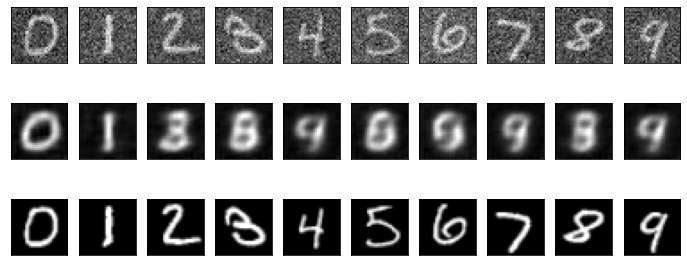

In [17]:

plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+11)
    plt.imshow(x_output_example.detach().numpy()[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
      
    plt.subplot(3,10,i+11+10)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])





## B) 
Implemented the equation 4.

$$
\begin{equation*}
    argmin ||x_{noisy}-g(z_{estimate}) ||^2_2+\beta||z_{estimate||^2_2
\end{equation*}
$$

In [ ]:
## implement eqn 4.

no_iterations = 1000
learning_rate = 1e-2
beta = 0.01
estimated_latent = nn.Parameter(torch.randn(10,16))
optimizer_map = torch.optim.Adam([estimated_latent],lr = learning_rate)






### Plot MAP